# Score clustering results

In [1]:
# when you run this code cell, some packages will throw an error bc they are not installed.  Install packages with the above code cell
import numpy as np # numerical Python
import pandas as pd # dataframe manipulation package.  Like Excel on steroids
import matplotlib # plotting library.  Figures, plots, etc.
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm, trange # puts a fancy progress bar on any for loop
import os # operating system.  Changes file path, etc.
import sys # system.  Sys.exit() will terminate program at any line.  Useful for debugging
import skimage # scientific python for image reading and processing
from skimage.io import imread # reads an image into Python
import tifffile as tf # alternative package to read image into Pypthon
import scipy # scientific python.  Like numpy but more advanced math
import seaborn as sns # like matplotlib. Alternative plotting library
# import napari # 3D image viewer for microscope images in Python
import dask
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import sklearn
import sklearn.metrics

sns.set_style('whitegrid')

# directories and inputs

In [18]:
dataPath = r"Y:\coskun-lab\Zhou\4_HCR\2D_analyses_pipelines\merfish_results\cluster_comparison"
fn_l = os.listdir(dataPath)
fn_l.sort()

# read clustering results and score

In [14]:
os.chdir(dataPath)
pklFiles = [f for f in os.listdir() if f.endswith('.pkl')]
assert len(pklFiles) > 0

# order on fig: expression, correlation, network variance
# pklFiles[0], pklFiles[1] = pklFiles[1], pklFiles[0] # swap

cols = ['ClusterType', 'FowlkesMallows', 'Rand']
dfScores = pd.DataFrame(columns = cols)
for ii, fileName in enumerate(tqdm(pklFiles)): # each clusteirng result
    
    clusterType = fileName.split('v.')[0]
    clusterType = clusterType.replace('clustering', '').strip()
    
    data = pd.read_pickle(fileName)
    
    # scoring metrics
    fScore = sklearn.metrics.fowlkes_mallows_score(labels_true = data['Cell types'], 
                                                  labels_pred = data['Cluster'])
    
    rScore = sklearn.metrics.adjusted_rand_score(labels_true = data['Cell types'], 
                                                  labels_pred = data['Cluster'])
    
    # update dataframe
    dfSub = pd.DataFrame([clusterType, fScore, rScore])
    dfSub = dfSub.T
    dfSub.columns = cols
    dfScores = pd.concat([dfScores, dfSub])
    
dfScores.reset_index(drop = True, inplace = True)
dfScores.set_index(['ClusterType'], inplace = True)

# reverse rows to appear correctly on bar graph
# reversing a DataFrame
# retrieving row by reindex method
dfScores = dfScores.reindex(index=dfScores.index[::-1])

# capitalize method names
dfScores.index = [s.title() for s in dfScores.index.tolist()]

dfScores

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 65.49it/s]


,FowlkesMallows,Rand
Network Variance,0.540032,0.355543
Expression 9,0.458244,0.264806
Correlation 9,0.534064,0.349088


In [258]:
dfScores = dfScores.rename(index={'Network_Variability_Cluster_Comparison.Pkl':'Network Variability', 'Count_Cluster_2_Comparison.Pkl':'Expression', 'Patch_Correlation_Cluster_Comparison.Pkl':'Patch Correlation'})

In [259]:
dfScores

,FowlkesMallows,Rand
Patch Correlation,0.944033,0.888942
Network Variability,1.0,1.0
Expression,0.980954,0.962261


In [5]:
fs = []
rs = []
names = []
fn_l = os.listdir(dataPath)
fn_l.sort()
for fn in fn_l:
    if fn.endswith('pkl'):
        data = pd.read_pickle(os.path.join(dataPath, fn))
        temp = fn.split('_')
        temp = temp[:len(temp)-1]
        temp_name = ''
        for t in temp:
            temp_name = temp_name + ' '+t
        names.append(temp_name[1:])
        
        fScore = sklearn.metrics.fowlkes_mallows_score(labels_true = data['Cell types'], 
                                                      labels_pred = data['Cluster'])
        fs.append(fScore)
        
        rScore = sklearn.metrics.adjusted_rand_score(labels_true = data['Cell types'], 
                                                      labels_pred = data['Cluster'])
        rs.append(rScore)

In [33]:
df = pd.DataFrame(data)

# Merging clusters before evaluation

In [109]:
clusters = df.groupby('Cluster')
l = df['Cluster'].unique()
replacer = {}
for item in l:
    group = clusters.get_group(item)
    temp = group['Cell types'].value_counts()
    replacer[item] = temp.idxmax()
df = df.replace({"Cluster": replacer})

In [267]:
dfScores = {'FowlkesMallows':[], 'Rand':[]}
idx = []
for fn in fn_l:
    if fn.endswith('.pkl'):
        data = pd.read_pickle(os.path.join(dataPath, fn))
        df = pd.DataFrame(data)
        clusters = df.groupby('Cluster')
        l = df['Cluster'].unique()
        replacer = {}
        for item in l:
            group = clusters.get_group(item)
            temp = group['Cell types'].value_counts()
            replacer[item] = temp.idxmax()
        df = df.replace({"Cluster": replacer})
        name = fn.split('_')[0]
        idx.append(name)
        dfScores['FowlkesMallows'].append(sklearn.metrics.fowlkes_mallows_score(labels_true = df['Cell types'], 
                                                      labels_pred = df['Cluster']))
        dfScores['Rand'].append(sklearn.metrics.adjusted_rand_score(labels_true = df['Cell types'], 
                                                      labels_pred = df['Cluster']))

In [268]:
df

,Cell types,Cluster
0,Fibroblast,Fibroblast
1,Fibroblast,Fibroblast
2,Fibroblast,Fibroblast
3,Fibroblast,Fibroblast
4,Fibroblast,Fibroblast
...,...,...
101,U2-OS,U2-OS
102,U2-OS,U2-OS
103,U2-OS,U2-OS
104,U2-OS,U2-OS


In [186]:
dfScores

{'FowlkesMallows': [0.9809541246086272, 1.0, 0.9440331325991861],
 'Rand': [0.962260857063638, 1.0, 0.8889421348987661]}

In [187]:
dfScores = pd.DataFrame(data=dfScores, index=idx)

In [222]:
dfScores

,FowlkesMallows,Rand
Network Variance,0.719104,0.585505
Expression,0.52744,0.341391
Correlation,0.691728,0.548035


In [223]:
# dfScores = dfScores.rename(index={'patch': 'Patch Correlation','count':'Expression','network':'Network Variability'})
dfScores = dfScores.rename(index={'Correlation':'Patch Correlation','Network Variance':'Network Variability'})

In [224]:
dfScores

,FowlkesMallows,Rand
Network Variability,0.719104,0.585505
Expression,0.52744,0.341391
Patch Correlation,0.691728,0.548035


# bar graph clustering scores

In [123]:
sns.set(font_scale = 2)

In [205]:
dfScores

,FowlkesMallows,Rand
Patch_Correlation_Cluster_Comparison.Pkl,0.944033,0.888942
Network_Variability_Cluster_Comparison.Pkl,1.0,1.0
Count_Cluster_Comparison.Pkl,0.717011,0.516275


In [215]:
# rename labels as desired
dfScores.rename(index = {'Count_Cluster_Comparison.Pkl': 'Expression',
                         'Network_Variability_Cluster_Comparison.Pkl': 'Network Variability',
                         'Patch_Correlation_Cluster_Comparison.Pkl': 'Patch Correlation'},
                inplace = True)
# dfScores = dfScores.loc[['High Variance Gene', 'All Gene', 'Correlation', 'Network Variance']]

In [207]:
dfScores['Features'] = dfScores.index.tolist()

In [260]:
dfScores = dfScores.reindex(['Expression','Patch Correlation','Network Variability'])

In [261]:
dfScores

,FowlkesMallows,Rand
Expression,0.980954,0.962261
Patch Correlation,0.944033,0.888942
Network Variability,1.0,1.0


In [262]:
from matplotlib import rcParams

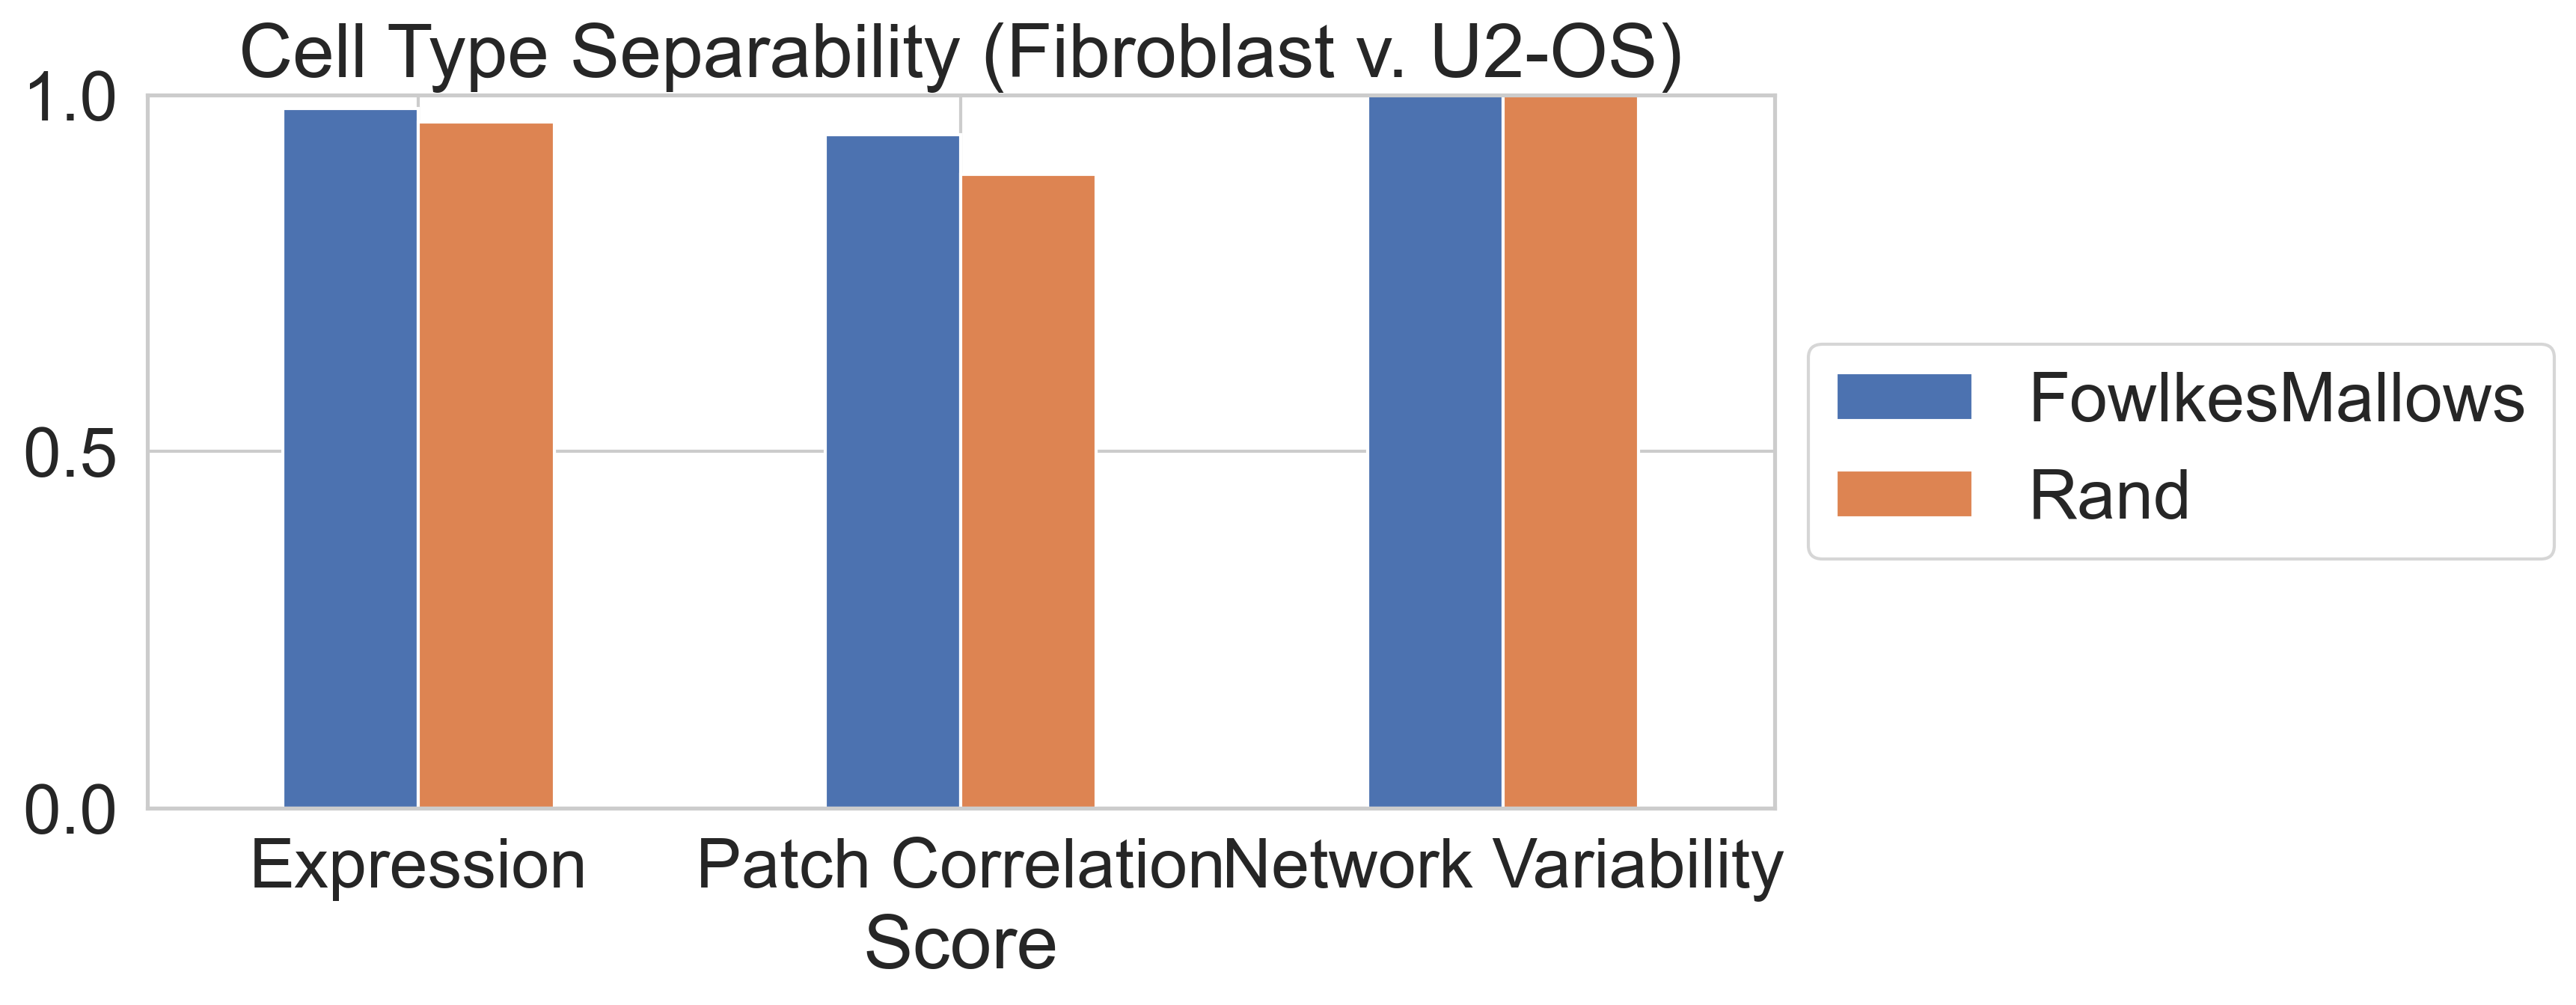

In [263]:
fig, ax = plt.subplots(1,1,figsize=(12,5),dpi = 300)
ax = dfScores.plot(kind = 'bar', ax = ax, rot = 45, ylim = [0, 1])
ax.set_title('Cell Type Separability (Fibroblast v. U2-OS)')
ax.set_ylabel('')
ax.set_xlabel('Score')

ax.set_xticklabels(['Expression','Patch Correlation','Network Variability'],rotation=0)
# ax.legend(ncol=len(cols), fontsize = 11)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))

# reduce number of y ticks
ax.locator_params(axis='y', nbins=3)
plt.tight_layout()
plt.savefig(r'Y:\coskun-lab\Zhou\4_HCR\2D_analyses_pipelines\merfish_analysis\figures\merfish 2 cluster comparison.png', format='png')

In [194]:
dfScores

,FowlkesMallows,Rand
Expression,0.980954,0.962261
Patch Correlation,0.944033,0.888942
Network Variability,1.000000,1.000000


In [195]:
sub_df = dfScores.filter(items=['FowlkesMallows'])

In [196]:
sub_df

,FowlkesMallows
Expression,0.980954
Patch Correlation,0.944033
Network Variability,1.000000


In [197]:
from matplotlib import rcParams

In [198]:
rcParams['figure.facecolor']='#ffffff'
rcParams['figure.edgecolor']='#000000'
rcParams['figure.frameon']=True
rcParams['axes.facecolor']='#ffffff'
rcParams['axes.edgecolor']='#000000'

In [176]:
rcParams.keys

<bound method Mapping.keys of RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '#000000',
          'axes.facecolor': '#ffffff',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'both

<AxesSubplot:>

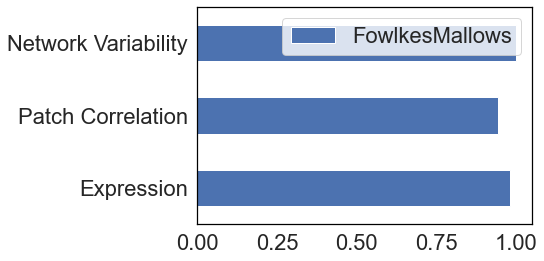

In [199]:
sub_df.plot.barh()

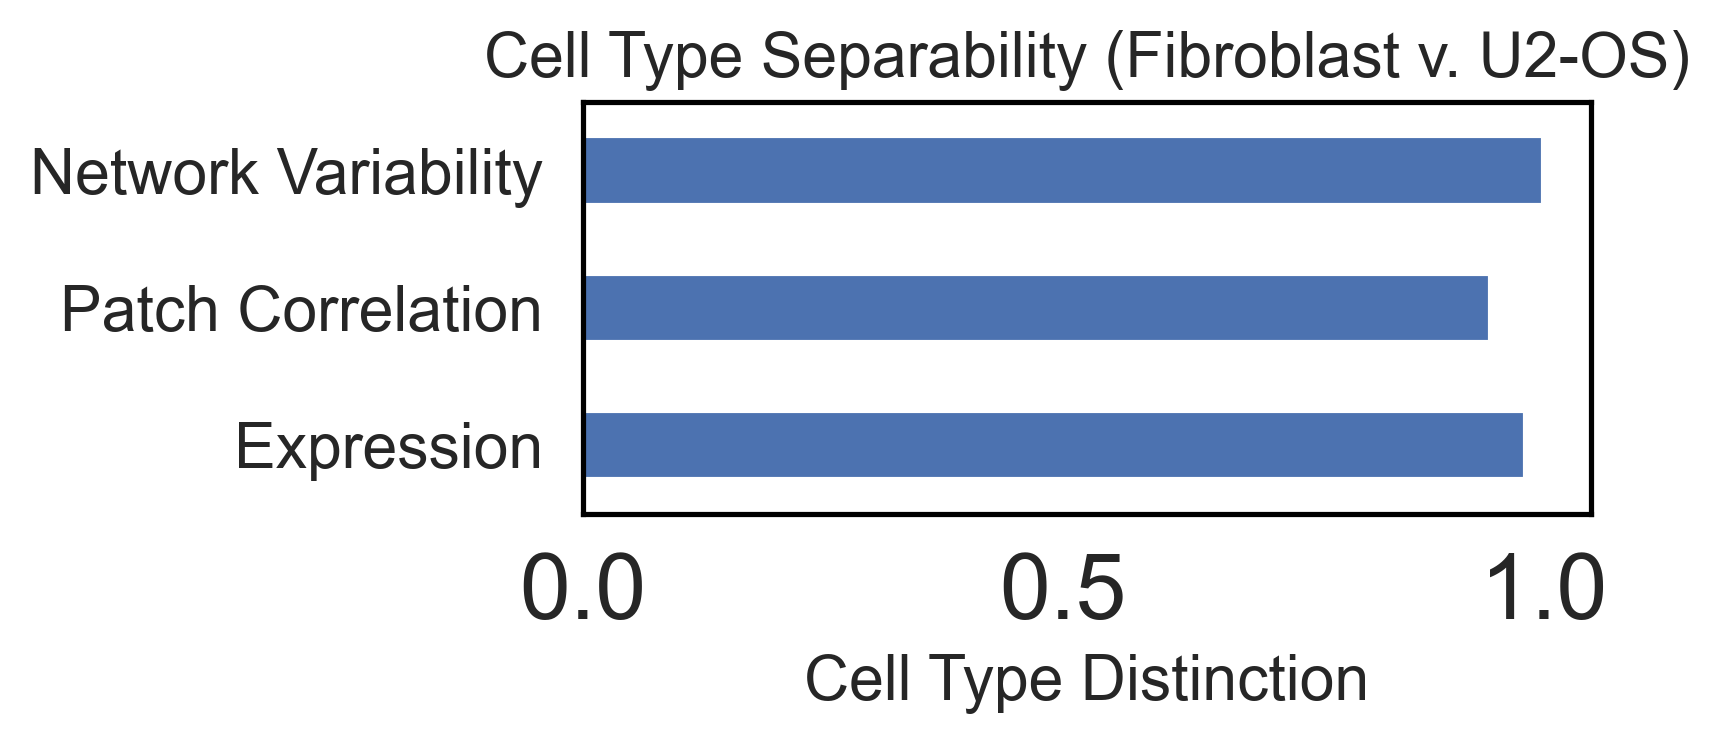

In [202]:
fig, ax = plt.subplots(1,1,figsize=(6,3),dpi = 300)
ax = sub_df.plot.barh(ax = ax, rot = 45, ylim = [0, 1])
# , color='#CC6600'
ax.set_title('Cell Type Separability (Fibroblast v. U2-OS)',fontsize=15)
ax.set_ylabel('')
ax.set_xlabel('Cell Type Distinction',fontsize=15)

ax.set_yticklabels(['Expression','Patch Correlation','Network Variability'],rotation=0,fontsize=15)
ax.get_legend().remove()

# reduce number of y ticks
ax.locator_params(axis='y', nbins=3)
# ax.set_xticklabels(['0.0','0.5','1.0'],fontsize=15)
plt.tight_layout()
plt.savefig(r'Y:\coskun-lab\Zhou\4_HCR\2D_analyses_pipelines\merfish_analysis\figures\merfish fig1 comparison.png')

In [94]:
c_patchface = rcParams['patch.facecolor']

In [98]:
rcParams['patch.facecolor'] = c_patchface

In [99]:
rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '#000000',
          'axes.facecolor': '#ffffff',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'both',
          'axes.grid.which'

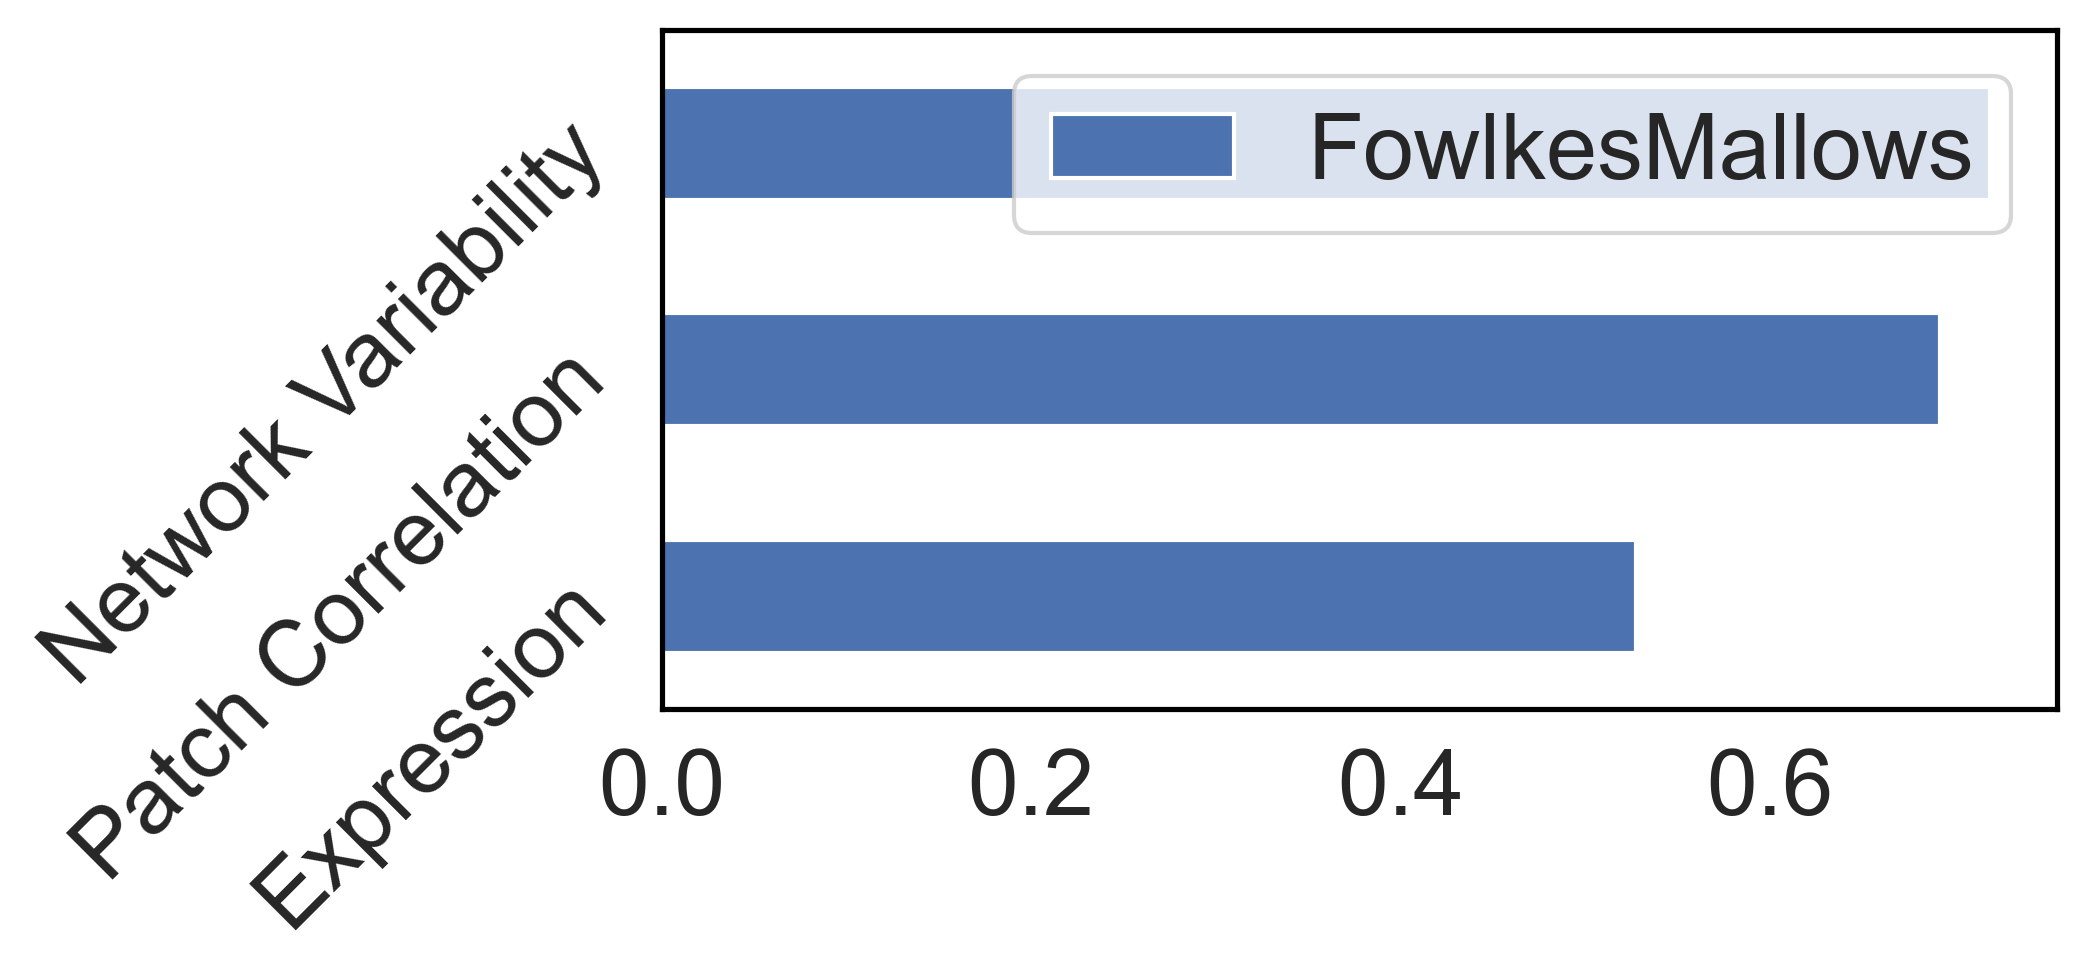

In [97]:
fig, ax = plt.subplots(1,1,figsize=(6,3),dpi = 300)
ax = sub_df.plot(kind = 'barh', ax = ax, rot = 45, ylim = [0, 1])
# DataFrame.plot.bar(x=None, y=None, **kwargs)

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(6,3),dpi = 300)
# ax = sub_df.plot(kind = 'barh', ax = ax, rot = 45, ylim = [0, 1])
# ax.set_title('Cell Type Separability (Fibroblast v. U2-OS)',fontsize=15)
# ax.set_ylabel('')
# ax.set_xlabel('Cell Type Distinction',fontsize=15)

# ax.set_yticklabels(['Expression','Patch Correlation','Network Variability'],rotation=0,fontsize=15)
# ax.get_legend().remove()

# # reduce number of y ticks
# ax.locator_params(axis='y', nbins=3)
# # ax.set_xticklabels(['0.0','0.5','1.0'],fontsize=15)
# plt.tight_layout()
# plt.savefig(r'Y:\coskun-lab\Zhou\4_HCR\2D_analyses_pipelines\merfish_analysis\figures\fibroblast u2os fig1 comparison.png')

#### Pertubation rand score

In [27]:
df = pd.DataFrame({'Rand Score':[0.939,0.867]}, index=['Original v. Perturbated','Original v. Random'])

In [28]:
df

,Rand Score
Original v. Perturbated,0.939
Original v. Random,0.867


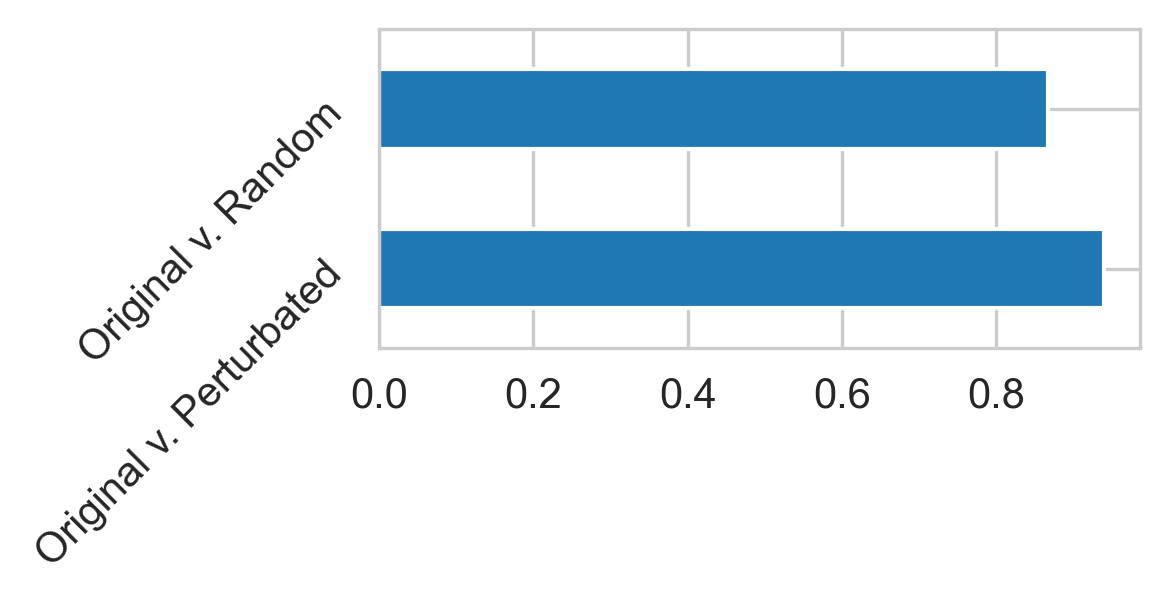

In [29]:
fig, ax = plt.subplots(1,1,figsize=(4,2),dpi = 300)
ax = df.plot(kind = 'barh', ax = ax, rot=45, ylim = [0, 1])
ax.legend().remove()
plt.tight_layout()
plt.savefig(r'.\figures\pixel clustering pertubation analysis.png')

# Confusion matrix, treat clustering as a classification problem

In [2]:
from sklearn.metrics import confusion_matrix

## merfish dataset

In [19]:
confusions = {}
idx = []
for fn in fn_l:
    if fn.endswith('.pkl'):
        data = pd.read_pickle(os.path.join(dataPath, fn))
        df = pd.DataFrame(data)
        clusters = df.groupby('Cluster')
        l = df['Cluster'].unique()
        replacer = {}
        for item in l:
            group = clusters.get_group(item)
            temp = group['Cell types'].value_counts()
            replacer[item] = temp.idxmax()
        df = df.replace({"Cluster": replacer})
        name = fn.split('_')[0]
        idx.append(name)
        confusion = confusion_matrix(df['Cell types'].tolist(),
                                     df['Cluster'].tolist(),labels=['Fibroblast','U2-OS'])
        confusion = pd.DataFrame(confusion,columns=['Fibroblast','U2-OS'],index=['Fibroblast','U2-OS'])
        confusions[name] = confusion

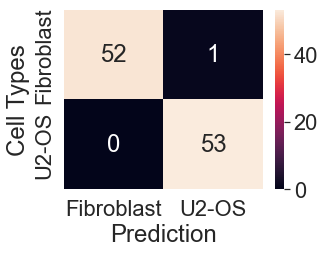

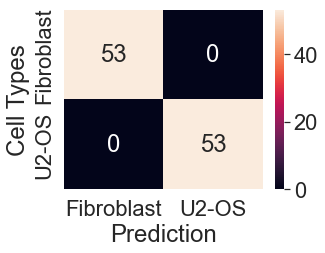

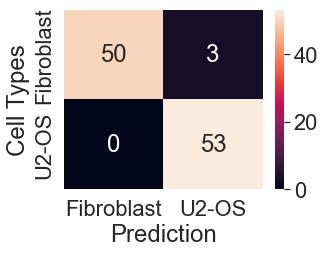

In [342]:
for k in confusions.keys():
    fig,ax = plt.subplots(1,1,figsize=(5,4))
    g = sns.heatmap(confusions[k],annot=True,ax=ax)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Cell Types')
    plt.tight_layout()
    # plt.savefig(r'Y:\coskun-lab\Zhou\4_HCR\2D_analyses_pipelines\merfish_analysis\figures\merfish confusion matrix '+ k +'.png')
    plt.show()

In [344]:
confusions.keys()

dict_keys(['count', 'network', 'patch'])

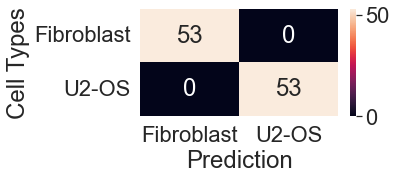

In [348]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
g = sns.heatmap(confusions['network'],annot=True,ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Cell Types')
plt.tight_layout()
plt.savefig(r'Y:\coskun-lab\Zhou\4_HCR\2D_analyses_pipelines\merfish_analysis\figures\merfish confusion matrix '+ k +' wide.png')
plt.show()

## seqFISH dataset

In [15]:
confusions = {}
idx = []
for fn in fn_l:
    if fn.endswith('.pkl'):
        data = pd.read_pickle(os.path.join(dataPath, fn))
        df = pd.DataFrame(data)
        clusters = df.groupby('Cluster')
        l = df['Cluster'].unique()
        replacer = {}
        for item in l:
            group = clusters.get_group(item)
            temp = group['Cell types'].value_counts()
            replacer[item] = temp.idxmax()
        df = df.replace({"Cluster": replacer})
        name = fn.split('_')[0]
        idx.append(name)
        confusion = confusion_matrix(df['Cell types'].tolist(),
                                     df['Cluster'].tolist(),labels=['HBM','HUC','HCH'])
        confusion = pd.DataFrame(confusion,columns=['HBM','HUC','HCH'],index=['HBM','HUC','HCH'])
        confusions[name] = confusion

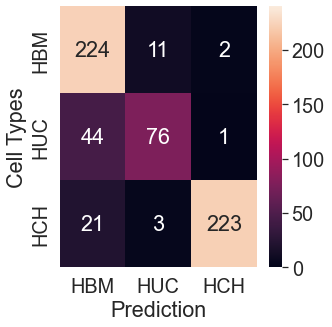

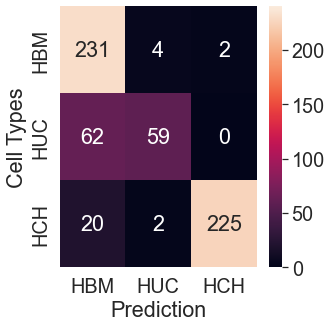

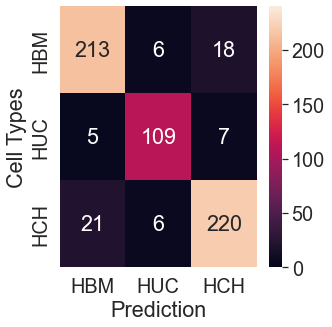

In [16]:
sns.set(font_scale=1.8)
for k in confusions.keys():
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    g=sns.heatmap(confusions[k],vmin=0,vmax=240,annot=True,fmt='g',ax=ax)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Cell Types')
    plt.tight_layout()
    plt.savefig(r'Y:\coskun-lab\Zhou\4_HCR\2D_analyses_pipelines\merfish_analysis\figures\seqfish confusion matrix '+ k +' 9 clusters.png')
    plt.show()

In [9]:
confusions.keys()

dict_keys(['correlation clustering v. cell type.pkl', 'expression clustering v. cell type.pkl', 'network variance clustering v. cell type.pkl'])

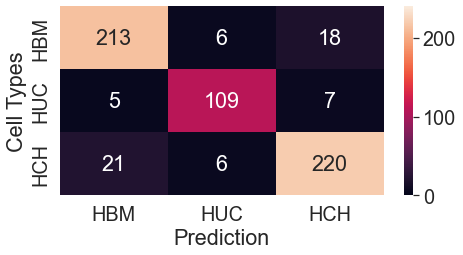

In [12]:
k = 'network variance clustering v. cell type.pkl'
sns.set(font_scale=1.8)
fig,ax = plt.subplots(1,1,figsize=(7,4))
g=sns.heatmap(confusions[k],vmin=0,vmax=240,annot=True,fmt='g',ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Cell Types')
plt.tight_layout()
plt.savefig(r'Y:\coskun-lab\Zhou\4_HCR\2D_analyses_pipelines\merfish_analysis\figures\seqfish confusion matrix '+ k +' wide.png')
plt.show()

# high variance genes clustering

In [7]:
df

,Cell types,Cluster
0,Fibroblast,Fibroblast
1,Fibroblast,Fibroblast
2,Fibroblast,Fibroblast
3,Fibroblast,Fibroblast
4,Fibroblast,Fibroblast
...,...,...
101,U2-OS,U2-OS
102,U2-OS,U2-OS
103,U2-OS,U2-OS
104,U2-OS,U2-OS


In [8]:
in_dir = r'Y:\coskun-lab\Zhou\4_HCR\2D_analyses_pipelines\seqfish_results\expression clustering v. cell type.pkl'
data = pd.read_pickle(in_dir)
df = pd.DataFrame(data)
clusters = df.groupby('Cluster')
l = df['Cluster'].unique()
replacer = {}
for item in l:
    group = clusters.get_group(item)
    temp = group['Cell types'].value_counts()
    replacer[item] = temp.idxmax()
df = df.replace({"Cluster": replacer})
# name = fn.split('_')[0]
# idx.append(name)
confusion = confusion_matrix(df['Cell types'].tolist(),
                             df['Cluster'].tolist(),labels=['HBM','HUC','HCH'])
confusion = pd.DataFrame(confusion,columns=['HBM','HUC','HCH'],index=['HBM','HUC','HCH'])
# confusions[name] = confusion

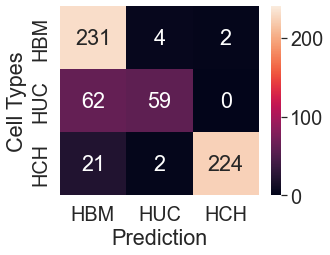

In [12]:
sns.set(font_scale=1.8)
fig,ax = plt.subplots(1,1,figsize=(5,4))
g=sns.heatmap(confusion,vmin=0,vmax=240,annot=True,fmt='g',ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Cell Types')
plt.tight_layout()
plt.savefig(r'Y:\coskun-lab\Zhou\4_HCR\2D_analyses_pipelines\merfish_analysis\figures\seqfish confusion matrix full genes.png')
plt.show()